# 关于变换

- 点的变换，通常存在，缩放、旋转、平移，例如对点P(x, y)进行旋转$\theta$度、缩放scale倍、平移ox，oy
- 如果用矩阵进行表示则有：
- 旋转变换：
$$
\left\{
\begin{array}{rc}
x' \\
y'
\end{array}
\right\}
=
\left\{
\begin{array}{rc}
cos(\theta) & -sin(\theta) \\
sin(\theta) & cos(\theta)
\end{array}
\right\}
\left\{
\begin{array}{rc}
x \\
y
\end{array}
\right\}
$$

<img src="formula.png"/>

- 又因为opencv的图像坐标，原点在左上角，y+向下，因此旋转变换矩阵在图像上时是：
$$
\left\{
\begin{array}{rc}
x' \\
y'
\end{array}
\right\}
=
\left\{
\begin{array}{rc}
cos(\theta) & sin(\theta) \\
-sin(\theta) & cos(\theta)
\end{array}
\right\}
\left\{
\begin{array}{rc}
x \\
y
\end{array}
\right\}
$$

In [1]:
import cv2
import numpy as np
cv2.getRotationMatrix2D((0, 0), 60, 1), np.sin(60/180.0*np.pi)

(array([[ 0.5      ,  0.8660254,  0.       ],
        [-0.8660254,  0.5      ,  0.       ]]),
 0.8660254037844386)

- 缩放变换
$$
\left\{
\begin{array}{rc}
x' \\
y'
\end{array}
\right\}
=
\left\{
\begin{array}{rc}
scale & 0 \\
0 & scale
\end{array}
\right\}
\left\{
\begin{array}{rc}
x \\
y
\end{array}
\right\}
$$

- 缩放+旋转变换
$$
\left\{
\begin{array}{rc}
x' \\
y'
\end{array}
\right\}
=
\left\{
\begin{array}{rc}
cos(\theta) \times scale & sin(\theta) \times scale \\
-sin(\theta) \times scale & cos(\theta) \times scale
\end{array}
\right\}
\left\{
\begin{array}{rc}
x \\
y
\end{array}
\right\}
$$

In [2]:
theta = 0.8
scale = 2
rot = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]
])

sca = np.array([
    [scale, 0],
    [0, scale]
])

np.allclose(rot @ sca, sca @ rot)

True

- 平移变换
$$
\left\{
\begin{array}{rc}
x' \\
y'
\end{array}
\right\}
=
\left\{
\begin{array}{rc}
1 & 0 \\
0 & 1
\end{array}
\right\}
\left\{
\begin{array}{rc}
x \\
y
\end{array}
\right\}
+
\left\{
\begin{array}{rc}
ox \\
oy
\end{array}
\right\}
$$

- 这时候问题来了，平移是加法运算，就没办法合并为一个矩阵了，怎么办？

# 齐次坐标定义
## 用(x, y, w)，来表示点$P(\frac{x}{w}, \frac{y}{w}, 1)$

- 平移变换
$$
\left\{
\begin{array}{rc}
x' \\
y' \\
w \\
\end{array}
\right\}
=
\left\{
\begin{array}{rc}
1 & 0 & ox \\
0 & 1 & oy \\
0 & 0 & 1
\end{array}
\right\}
\left\{
\begin{array}{rc}
x \\
y \\
1
\end{array}
\right\}
$$

- 缩放+旋转+平移变换（注意此时顺序有关，旋转缩放后，再平移的样子，也就是P' = T x S x R x P）
$$
\left\{
\begin{array}{rc}
x' \\
y' \\
w
\end{array}
\right\}
=
\left\{
\begin{array}{rc}
cos(\theta) \times scale & sin(\theta) \times scale & ox  \\
-sin(\theta) \times scale & cos(\theta) \times scale & oy \\
0 & 0 & 1
\end{array}
\right\}
\left\{
\begin{array}{rc}
x \\
y \\
1
\end{array}
\right\}
$$

## 旋转矩阵的逆，是其转置即
# $R^{-1} = R^{T}$

## 反变换，对变换矩阵求逆即可
## $P' = MP$
## $P = M^{-1}P'$

## 对于平时目标检测推理而言，通常需要图像等比缩放并且居中

<img src="warp2.png"/>

# 分解为三个步骤如下

<img src="step1.png"/>

<img src="step2.png"/>

$$
scale = min(\frac{Dst.width}{Origin.width}, \frac{Dst.height}{Origin.height}) \\
 \\
M = 
\left\{
\begin{array}{ll}
scale & 0 & -\frac{scale \times Origin.width}{2} + \frac{Dst.width}{2} \\
0 & scale & -\frac{scale \times Origin.height}{2} + \frac{Dst.height}{2} \\
\end{array}
\right\}
$$

$$
\left\{
\begin{array}{ll}
x' \\
y' \\
\end{array}
\right\}
=  
\left\{
\begin{array}{ll}
scale & 0 & -\frac{scale \times Origin.width}{2} + \frac{Dst.width}{2} \\
0 & scale & -\frac{scale \times Origin.height}{2} + \frac{Dst.height}{2} \\
\end{array}
\right\}
\left\{
\begin{array}{ll}
x \\
y \\
1
\end{array}
\right\}
$$

# 由于变换比较简单，那么逆变换则可以很容易的写出来

$$
k = scale \\
b1 = -\frac{scale \times Origin.width}{2} + \frac{Dst.width}{2} \\
b2 = -\frac{scale \times Origin.height}{2} + \frac{Dst.height}{2} \\
x' = kx + b1 \\
y' = ky + b2 \\
x  = \frac{x' - b1}{k} = x'\times \frac{1}{k} + (-\frac{b1}{k}) \\
y = \frac{y' - b2}{k} = y'\times \frac{1}{k} + (-\frac{b2}{k}) \\
M^{-1} = \left\{
\begin{array}{ll}
\frac{1}{k} & 0 & -\frac{b1}{k} \\
0 & \frac{1}{k} & -\frac{b2}{k} \\
\end{array}
\right\}
$$

In [3]:
origin = np.array([300, 500], dtype=float)
dst = np.array([640, 640], dtype=float)
scale = min(dst/origin)

M = np.array([
    [scale, 0, -(scale * origin[0] * 0.5) + (dst[0] * 0.5)],
    [0, scale, -(scale * origin[1] * 0.5) + (dst[1] * 0.5)],
    [0, 0, 1]
])
M

array([[  1.28,   0.  , 128.  ],
       [  0.  ,   1.28,   0.  ],
       [  0.  ,   0.  ,   1.  ]])

In [4]:
np.linalg.inv(M)

array([[   0.78125,    0.     , -100.     ],
       [   0.     ,    0.78125,    0.     ],
       [   0.     ,    0.     ,    1.     ]])

In [5]:
k = scale
b1 = M[0, 2]
b2 = M[1, 2]

invM = np.array([
    [1 / k, 0, -b1/k],
    [0, 1 / k, -b2/k]
])
invM

array([[   0.78125,    0.     , -100.     ],
       [   0.     ,    0.78125,   -0.     ]])

# 对正变换逆变换做个实验看看

In [25]:
def inv_align(M):
    k = M[0, 0]
    b1 = M[0, 2]
    b2 = M[1, 2]
    return np.array([
        [1/k, 0, -b1/k],
        [0, 1/k, -b2/k]
    ])

def align(image, dst_size):
    
    oh, ow = image.shape[:2]
    dh, dw = dst_size
    scale = min(dw/ow, dh/oh)
    
    M = np.array([
        [scale, 0, -scale * ow * 0.5 + dw * 0.5],
        [0, scale, -scale * oh * 0.5 + dh * 0.5]
    ])
    return cv2.warpAffine(image, M, dst_size), M, inv_align(M)

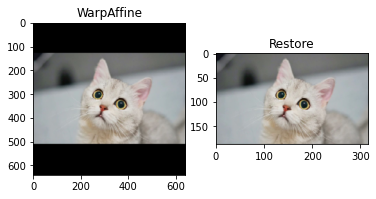

In [26]:
import matplotlib.pyplot as plt

cat1 = cv2.imread("cat1.png")
acat1, M, inv = align(cat1, (640, 640))

plt.subplot(1, 2, 1)
plt.title("WarpAffine")
plt.imshow(acat1[..., ::-1])

resact1 = cv2.warpAffine(acat1, inv, cat1.shape[:2][::-1])
plt.subplot(1, 2, 2)
plt.title("Restore")
plt.imshow(resact1[..., ::-1])

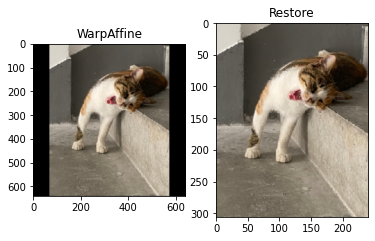

In [27]:
import matplotlib.pyplot as plt

cat2 = cv2.imread("cat2.png")
acat2, M, inv = align(cat2, (640, 640))

plt.subplot(1, 2, 1)
plt.title("WarpAffine")
plt.imshow(acat2[..., ::-1])

resact2 = cv2.warpAffine(acat2, inv, cat2.shape[:2][::-1])
plt.subplot(1, 2, 2)
plt.title("Restore")
plt.imshow(resact2[..., ::-1])

# 线性插值

In [12]:
p0 = 20    # 冷水
p1 = 100   # 热水
pos = 0.6  # 应该多少度

value = (1 - pos) * p0 + pos * p1
value

68.0

<img src="interp_line.png"/>

# 双线性插值

In [54]:
# 0, 0
p0 = 3;        p1 = 5
p2 = 6;        p3 = 8  
#                    1, 1

# x , y
pos = 0.6, 0.8

p0_area = (1 - pos[0]) * (1 - pos[1])
p1_area = pos[0] * (1 - pos[1])
p2_area = (1 - pos[0]) * pos[1]
p3_area = pos[0] * pos[1]

value = p0_area * p0 + p1_area * p1 + p2_area * p2 + p3_area * p3
value

6.6

<img src="interp_line2.png"/>

# 实现一个warpaffine，双线性插值

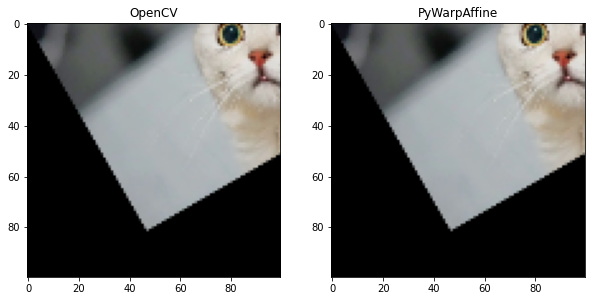

In [55]:
def pyWarpAffine(image, M, dst_size, constant=(0, 0, 0)):
    
    # 注意输入的M矩阵格式，是Origin->Dst
    # 而这里需要的是Dst->Origin，所以要取逆矩阵
    M = cv2.invertAffineTransform(M)
    constant = np.array(constant)
    ih, iw   = image.shape[:2]
    dw, dh   = dst_size
    dst      = np.full((dh, dw, 3), constant, dtype=np.uint8)
    irange   = lambda p: p[0] >= 0 and p[0] < iw and p[1] >= 0 and p[1] < ih
    
    for y in range(dh):
        for x in range(dw):
            
            homogeneous = np.array([[x, y, 1]]).T
            ox, oy = M @ homogeneous
            
            low_ox = int(np.floor(ox))
            low_oy = int(np.floor(oy))
            high_ox = low_ox + 1
            high_oy = low_oy + 1
            
            # p0     p1
            #      o
            # p2     p3
            
            pos = ox - low_ox, oy - low_oy
            p0_area = (1 - pos[0]) * (1 - pos[1])
            p1_area = pos[0] * (1 - pos[1])
            p2_area = (1 - pos[0]) * pos[1]
            p3_area = pos[0] * pos[1]
            
            p0 = low_ox, low_oy
            p1 = high_ox, low_oy
            p2 = low_ox, high_oy
            p3 = high_ox, high_oy
            p0_value = image[p0[1], p0[0]] if irange(p0) else constant
            p1_value = image[p1[1], p1[0]] if irange(p1) else constant
            p2_value = image[p2[1], p2[0]] if irange(p2) else constant
            p3_value = image[p3[1], p3[0]] if irange(p3) else constant
            dst[y, x] = p0_area * p0_value + p1_area * p1_value + p2_area * p2_value + p3_area * p3_value
            # 交换bgr  rgb
            # normalize ->  -mean /std
            # 1行代码实现normalize , /255.0
            # bgr bgr bgr -> bbb ggg rrr
            # focus
            # focus offset, 1行代码实现focus
            
    return dst

            
cat1 = cv2.imread("cat1.png")
#acat1_cv, M, inv = align(cat1, (100, 100))
M = cv2.getRotationMatrix2D((0, 0), 30, 0.5)
acat1_cv = cv2.warpAffine(cat1, M, (100, 100))
acat1_py = pyWarpAffine(cat1, M, (100, 100))

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("OpenCV")
plt.imshow(acat1_cv[..., ::-1])

plt.subplot(1, 2, 2)
plt.title("PyWarpAffine")
plt.imshow(acat1_py[..., ::-1])